Actions received by class: 5
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent 0 is ongoing!
win status agent 0 = False


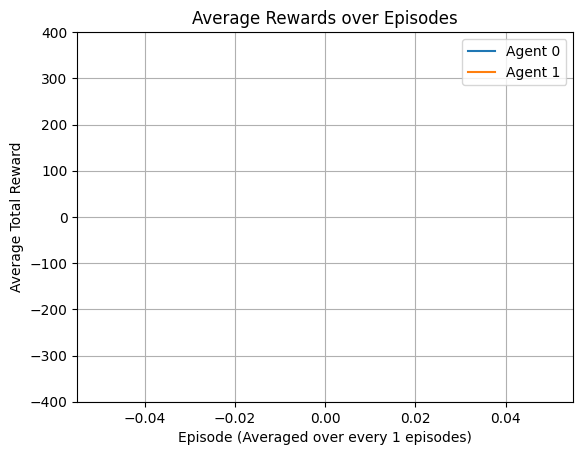

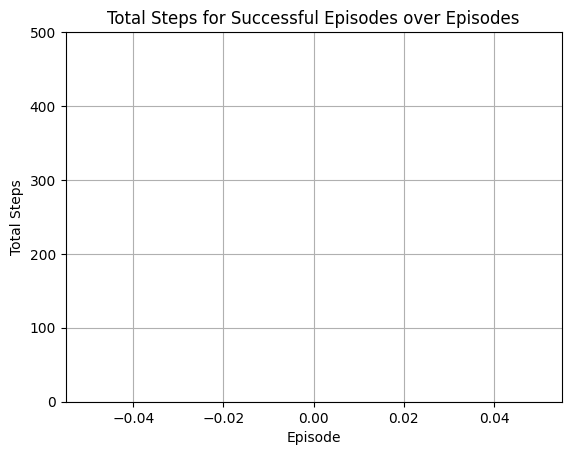

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from environment_ma_reward_distance_dynamic_notrandom import Env

class QLearningAgent:
    def __init__(self, env, actions):
        print(f"Actions received by class: {actions}")
        self.env = env
        self.actions = actions
        self.learning_rate = 0.1  
        self.discount_factor = 0.9
        self.epsilon = 0.1  
        self.epsilon_decay = 0.995  
        self.epsilon_min = 0.01  
        self.q_tables = [defaultdict(lambda: [0.0] * (actions + 1)) for _ in range(env.num_agents)]  
        self.rewards_per_episode = [[] for _ in range(env.num_agents)] 
        self.successful_episodes = [0] * env.num_agents  
        self.total_successful_episodes = 0  
        self.leniency = 1.0  # Start with high leniency
        self.leniency_decay = 0.99  # Gradually decrease leniency
        self.min_leniency = 0.1  # Minimum leniency

    def learn(self, agent_idx, state, physical_action, reward, next_state, comm_action):
        physical_state = tuple(state[0])
        physical_next_state = tuple(next_state[0])

        current_q = self.q_tables[agent_idx][physical_state][physical_action]
        max_next_q = max(self.q_tables[agent_idx][physical_next_state])

        # Apply leniency to negative rewards in early learning
        if reward < 0:
            reward *= self.leniency

        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_tables[agent_idx][physical_state][physical_action] = new_q

        # Communication-based collaboration
        if comm_action is not None:
            print(f"Agent {agent_idx} sends message: {comm_action}")
            self.update_from_communication(agent_idx, state, comm_action)

    def update_from_communication(self, agent_idx, state, comm_action):
        received_q_values = comm_action['q_values']  
        state = tuple(state[0])
        for action, q_value in enumerate(received_q_values):
            self.q_tables[agent_idx][state][action] = max(self.q_tables[agent_idx][state][action], q_value)

    def print_q_table(self, agent_id):
        print(f"Q-table for Agent {agent_id}:")
        for state, actions in self.q_tables[agent_id].items():
            print(f"  State: {state}")
            for action, q_value in enumerate(actions):
                print(f"    Action: {action}, Q-value: {q_value:.5f}")
        print(f"End of Q-table for Agent {agent_id}\n")

    def get_action(self, agent_idx, state):
        physical_state = tuple(state[0])
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            state_action = self.q_tables[agent_idx][physical_state]
            return self.arg_max(state_action)

    def choose_action(self, agent_idx, state):
        physical_action = self.get_action(agent_idx, state)
        communication_action = None

        if not self.env.is_agent_silent and np.random.rand() < 0.1:
            communication_action = self.get_communication_action(agent_idx, state)
        
        return (physical_action, communication_action)

    def get_communication_action(self, agent_idx, state):
        state = tuple(state[0])
        q_values = self.q_tables[agent_idx][state]
        return {'q_values': q_values}

    @staticmethod
    def arg_max(state_action):
        max_value = max(state_action)
        max_indices = [i for i, val in enumerate(state_action) if val == max_value]
        return random.choice(max_indices)

    def run_episodes(self, num_episodes):
        success_steps = []

        for episode in range(num_episodes):
            states = self.env.reset()
            episode_reward = [0] * self.env.num_agents  
            dones = [False] * self.env.num_agents

            while not all(dones):
                combination_actions = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    physical_action, comm_action = self.choose_action(agent_idx, state)
                    combination_actions.append((physical_action, comm_action))

                next_states, rewards, dones = self.env.step(combination_actions)
                
                for agent_idx in range(self.env.num_agents):
                    physical_action = combination_actions[agent_idx][0]
                    comm_action = combination_actions[agent_idx][1]
                    state = states[agent_idx]
                    reward = rewards[agent_idx]
                    next_state = next_states[agent_idx]

                    self.learn(agent_idx, state, physical_action, reward, next_state, comm_action)
                    episode_reward[agent_idx] += reward

                states = next_states
                self.env.render()

            # Decrease leniency after each episode
            self.leniency = max(self.leniency * self.leniency_decay, self.min_leniency)

            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        self.plot_rewards_per_episode(episode_reward)
        self.plot_success_steps(success_steps)

    def plot_rewards_per_episode(self, rewards, window=1):
        for agent_idx in range(self.env.num_agents):
            moving_avg_rewards = [np.mean(rewards[agent_idx][i:i + window]) for i in range(0, len(rewards[agent_idx]), window)]
            plt.plot(moving_avg_rewards, label=f'Agent {agent_idx}')
        
        plt.xlabel(f'Episode (Averaged over every {window} episodes)')
        plt.ylabel('Average Total Reward')
        plt.title('Average Rewards over Episodes')
        plt.legend()
        plt.ylim(-400, 400)
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_success_steps(success_steps):
        plt.plot(success_steps)
        plt.xlabel('Episode')
        plt.ylabel('Total Steps')
        plt.title('Total Steps for Successful Episodes over Episodes')
        plt.ylim(top=500)
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    num_agents = 2
    num_obstacles = 3
    obstacles_random_steps = 30
    is_agent_silent = False
    episodes=89
    env = Env(num_agents=num_agents, num_obstacles=num_obstacles, obstacles_random_steps = obstacles_random_steps, is_agent_silent=is_agent_silent)
    num_actions = len(env.action_space)
    agent = QLearningAgent(env, num_actions)

    agent.run_episodes(episodes)

